# Introduction to machine learning: predicting diabetes

In [1]:
suppressMessages({
    library(tidyverse)
    library(ggsci)
    library(caret)
    library(magrittr)
    library(mlbench)
    library(gtsummary)
    library(gt)
    library(patchwork)
    library(svglite)
    library(showtext)
})

showtext_auto()

theme_set(theme_minimal())

In [2]:
draw_prediction_space <- function (df, slope=NULL, intercept=NULL) {
    df %<>% mutate(diabetes=as.factor(if_else(diabetes==T, "diabetes", "non-diabetes")))
    
    max_x <- max(df$glucose)
    max_y <- max(df$bmi)
    
    p <- df %>%
        ggplot(aes(x=glucose, y=bmi, color=diabetes)) +
        geom_point(alpha=0.8, size=1, stroke=0) +
        scale_color_npg(name="") +
        xlim(0, max_x) +
        ylim(0, max_y) +
        xlab("Glucose level") +
        ylab("BMI")
    
    if (!is.null(slope)) {
        p <- p +
            geom_abline(slope = slope, intercept = intercept)
        
        xy <- expand_grid(x=seq(0, max_x, by = 1), y=seq(0, max_y, by = 1)) %>%
            mutate(diabetes=sign(-y+slope*x+intercept)==-1) %>%
            mutate(diabetes=as.factor(if_else(diabetes==T, "diabetes", "non-diabetes")))
        
        count_hits <- df %>%
            mutate(pred=sign(-bmi+slope*glucose+intercept)==-1) %>%
            mutate(pred=as.factor(if_else(pred==T, "diabetes", "non-diabetes"))) %>%
            mutate(hit=pred==diabetes) %>%
            pull(hit) %>%
            sum()
                
        p <- p +
            geom_point(data=xy, aes(x=x, y=y, color=diabetes), alpha=0.1, shape=15, size=1, stroke=0) +
            ggtitle(str_glue("Accuracy: {round(100*(count_hits / nrow(df)), 2)}%"))
    }

    
    return(p)
}

## Data loading

In [3]:
data("PimaIndiansDiabetes")

dia <- PimaIndiansDiabetes %>%
    data.frame() %>%

    mutate(diabetes=as.factor(diabetes=="pos")) %>%
    rename(bmi=mass) %>%
    select(c(glucose, bmi, diabetes))

dia %>% head

p<- dia %>%
    draw_prediction_space()+
    theme(legend.position="bottom")

ggsave(file="init.svg", plot=p, width=3, height=3)

IRdisplay::display_html("<img width='500px' height='500px' src='init.svg'>")

,glucose,bmi,diabetes
,<dbl>,<dbl>,<fct>
1,148,33.6,TRUE
2,85,26.6,FALSE
3,183,23.3,TRUE
4,89,28.1,FALSE
5,137,43.1,TRUE
6,116,25.6,FALSE


## Exploratory data analysis

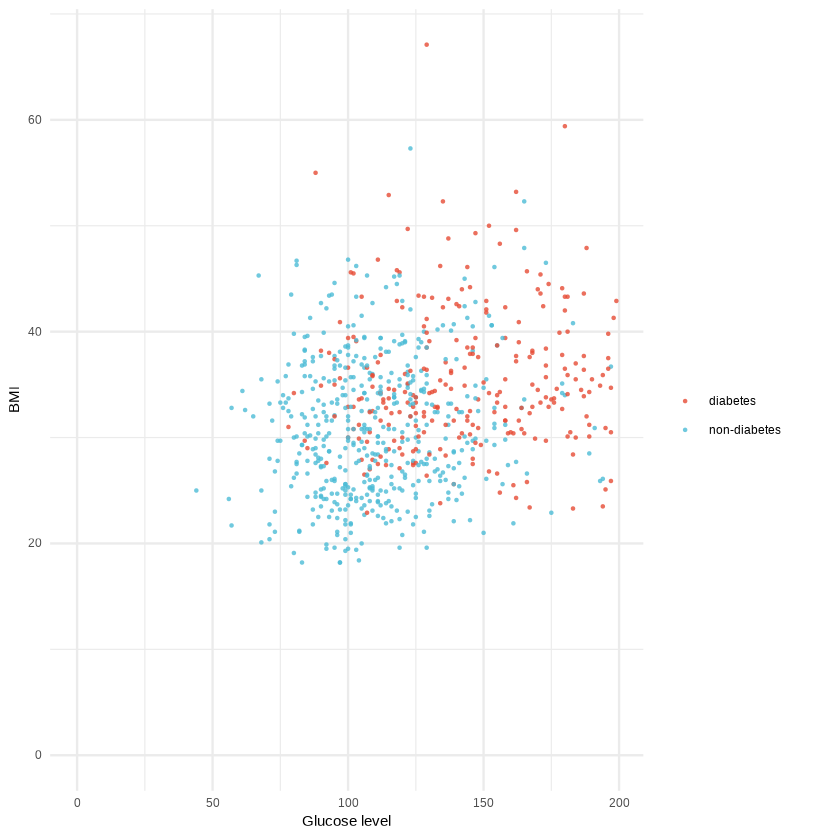

In [4]:
dia_clean <- dia %>%
    filter(bmi>0) %>%
    filter(glucose>0)

dia_clean %>%
    draw_prediction_space()

## Naive prediction model

In [5]:
dia_clean %>% group_by(diabetes) %>% count(name = "count") %>% ungroup() %>% gt() %>% as_raw_html() %>% as.character() %>% IRdisplay::display_html()
print(str_glue("Accuracy: {round(100*(dia_clean %>% filter(diabetes==F) %>% nrow) / nrow(dia_clean), 2)}%"))

<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 
 diabetes 
 count 
 
 
 
 FALSE 
 488 
 TRUE 
 264

Accuracy: 64.89%


## Linear prediction model

In [6]:
p1 <- draw_prediction_space(dia_clean, intercept=60, slope=-0.1)
p2 <- draw_prediction_space(dia_clean, intercept=200, slope=-3)
p3 <- draw_prediction_space(dia_clean, intercept=80, slope=-0.3)

p <- (p1+p2+p3+plot_layout(guides = "collect"))&theme(legend.position = "bottom")

ggsave(file="linpred_manual.svg", plot=p, width=9, height=3)
IRdisplay::display_html("<img width='1000px' height='500px' src='linpred_manual.svg'>")

In [7]:
svm_slope_intercept <- function (df) {
    X <- df %>% select(glucose, bmi)
    model <- train(
                  x=X,
                  y=df$diabetes, 
                  method="svmLinear")$finalModel
    
    means <- X %>% colMeans
    sds <- X %>% summarize_all(sd) %>% unlist

    coefs <- model@coef[[1]]
    mat <- model@xmatrix[[1]]

    w <- ((coefs %*% mat) %>% c)

    slope <- -(w[1]*sds[2])/(w[2]*sds[1])
    intercept <- (w[1]*means[1]*sds[2])/(sds[1]*w[2]) + means[2] + (model@b * sds[2]) / w[2]
    return(list("slope"=slope, "intercept"=intercept))
}

In [8]:
set.seed(1)
res <- svm_slope_intercept(dia_clean)
p <- draw_prediction_space(dia_clean, intercept=res$intercept, slope=res$slope)&theme(legend.position = "bottom")

ggsave(file="svm.svg", plot=p, width=3, height=3)

IRdisplay::display_html("<img width='500px' height='500px' src='svm.svg'>")

## Non-linear prediction model

In [9]:
draw_prediction_space_knn <- function (df, k) {
    df %<>% mutate(diabetes=as.factor(if_else(diabetes==T, "diabetes", "non-diabetes")))
    
    model <- train(
        x=df %>% select(glucose, bmi),
        y=df$diabetes, 
        method="knn", tuneGrid=data.frame(k=k))
    
    max_x <- max(df$glucose)
    max_y <- max(df$bmi)
    
    p <- df %>%
        ggplot(aes(x=glucose, y=bmi, color=diabetes)) +
        geom_point(alpha=0.8, size=1, stroke=0) +
        scale_color_npg(name="") +
        xlim(0, max_x) +
        ylim(0, max_y) +
        xlab("Glucose level") +
        ylab("BMI")

    xy <- expand_grid(glucose=seq(0, max_x, by = 1), bmi=seq(0, max_y, by = 1)) %>%
            mutate(diabetes=predict(model, newdata=.))
    
     count_hits <- df %>%
        mutate(hit=predict(model, newdata=.)==diabetes) %>%
        pull(hit) %>%
        sum()

    p <- p +
        geom_point(data=xy, aes(x=glucose, y=bmi, color=diabetes), alpha=0.1, shape=15, size=1, stroke=0) +
        ggtitle(str_glue("Accuracy: {round(100*(count_hits / nrow(df)), 2)}%")) +
        labs(subtitle = str_glue("k={k}"))
    
    return(p)
}

In [10]:
p1 <- draw_prediction_space_knn(dia_clean, 20)
p2 <- draw_prediction_space_knn(dia_clean, 5)
p3 <- draw_prediction_space_knn(dia_clean, 1)

p <- (p1+p2+p3+plot_layout(guides = "collect"))&theme(legend.position = "bottom")

ggsave(file="knn.svg", plot=p, width=9, height=3)
IRdisplay::display_html("<img width='1000px' height='500px' src='knn.svg'>")

## Training and test datasets

In [11]:
set.seed(1)

train_idx <- createDataPartition(dia_clean$diabetes, p = 0.8, list=F) %>% c
dia_clean_train <- dia_clean %>% slice(train_idx)
dia_clean_test <- dia_clean %>% slice(-train_idx)

res <- data.frame(k=integer(), train_acc=numeric(), test_acc=numeric())
for (k in 1:20) {
    model <- train(
        x=dia_clean_train %>% select(glucose, bmi),
        y=dia_clean_train$diabetes, 
        method="knn", tuneGrid=data.frame(k=k))

    train_yp <- predict(model, newdata=dia_clean_train %>% select(glucose, bmi))
    test_yp <- predict(model, newdata=dia_clean_test %>% select(glucose, bmi))
    
    train_acc <- 100*(sum(train_yp==dia_clean_train$diabetes) / nrow(dia_clean_train))
    test_acc <- 100*(sum(test_yp==dia_clean_test$diabetes) / nrow(dia_clean_test))

    res <- bind_rows(res, data.frame(k=k, train_acc=train_acc, test_acc=test_acc))
}

res %>% pivot_longer(cols = -k) %>%
    mutate(name=if_else(name=="test_acc", "Test dataset", "Training dataset")) %>%
    mutate(name=fct_relevel(name, "Training dataset", "Test dataset")) %>%
    ggplot(aes(x=k, y=value, color=name)) +
    geom_line() +
    scale_color_jama(name="Dataset type") +
    ylab("Accuracy [%]") -> p

ggsave(file="knn-train-test.svg", plot=p, width=5, height=3)
IRdisplay::display_html("<img width='600px' height='350px' src='knn-train-test.svg'>")

In [12]:
set.seed(1)

best_k <- 13

model <- train(
        x=dia_clean_train %>% select(glucose, bmi),
        y=dia_clean_train$diabetes, 
        method="knn", tuneGrid=data.frame(k=best_k))

    train_yp <- predict(model, newdata=dia_clean_train %>% select(glucose, bmi))
    test_yp <- predict(model, newdata=dia_clean_test %>% select(glucose, bmi))
    
    train_acc <- 100*(sum(train_yp==dia_clean_train$diabetes) / nrow(dia_clean_train))
    test_acc <- 100*(sum(test_yp==dia_clean_test$diabetes) / nrow(dia_clean_test))

print(str_glue("Accuracy of KNN for k=13 on test dataset: {round(test_acc, 2)}%"))

Accuracy of KNN for k=13 on test dataset: 74.5%


In [13]:
set.seed(1)

model <- train(
    x=dia_clean_train %>% select(glucose, bmi),
    y=dia_clean_train$diabetes, 
    method="svmLinear")
test_yp <- predict(model, newdata=dia_clean_test %>% select(glucose, bmi))
test_acc <- 100*(sum(test_yp==dia_clean_test$diabetes) / nrow(dia_clean_test))

print(str_glue("Accuracy of SVM on test dataset: {round(test_acc, 2)}%"))

Accuracy of SVM on test dataset: 75.17%
